# Sampling from multivariate lognormal distribution

In [1]:
import sandy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import lognorm

sns.set_style("whitegrid")

Small simple covariance matrix

In [3]:
# 3 parameters with similar mean values (but not identical!)
parameters = ['A', 'B', 'C']
x1 = 4
x2 = 5
x3 = 6
mean = np.array([x1, x2, x3])

# relative standard deviations
s1 = 10 / 100
s2 = 3 / 100    # small stdev
s3 = 60 / 100   # large stdev

# correlations between parameters
c12 = 0.2
c13 = -0.4
c23 = 0.5

# building covariance matrix
cov = sandy.CategoryCov(
    pd.DataFrame(
        [
            [s1 * x1 * s1 * x1,         s1 * x1 * s2 * x2 * c12,   s1 * x1 * s3 * x3 * c13],
            [s2 * x2 * s1 * x1 * c12,   s2 * x2 * s2 * x2,         s2 * x2 * s3 * x3 * c23],
            [s3 * x3 * s1 * x1 * c13,   s3 * x3 * s2 * x2 * c23,   s3 * x3 * s3 * x3],
        ], index=parameters, columns=parameters,
    )
)

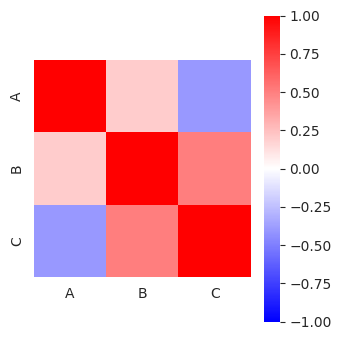

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)
ax.set_aspect("equal")
sns.heatmap(data=cov.get_corr().data, cmap='bwr', vmin=-1, vmax=1, ax=ax)
fig.tight_layout();

Let's convert mean vector and convariance matrix to relative terms.

In [5]:
cov_r = cov.corr2cov(1/mean)
cov_r.get_std()

A   1.00000e-01
B   3.00000e-02
C   6.00000e-01
Name: STD, dtype: float64

In [6]:
mean_r = mean / mean
mean_r

array([1., 1., 1.])

For parameters with medium/large standard deviations the left tail with a Normal distribution spans in the negative range.
For many nuclear data types, negative values do not have a physical meaning.

In [7]:
data = cov_r.sampling(5000).data.T
data.index.name = "PARAM"
data.columns.name = "SMP"
data = data.stack().rename("VAL").reset_index()

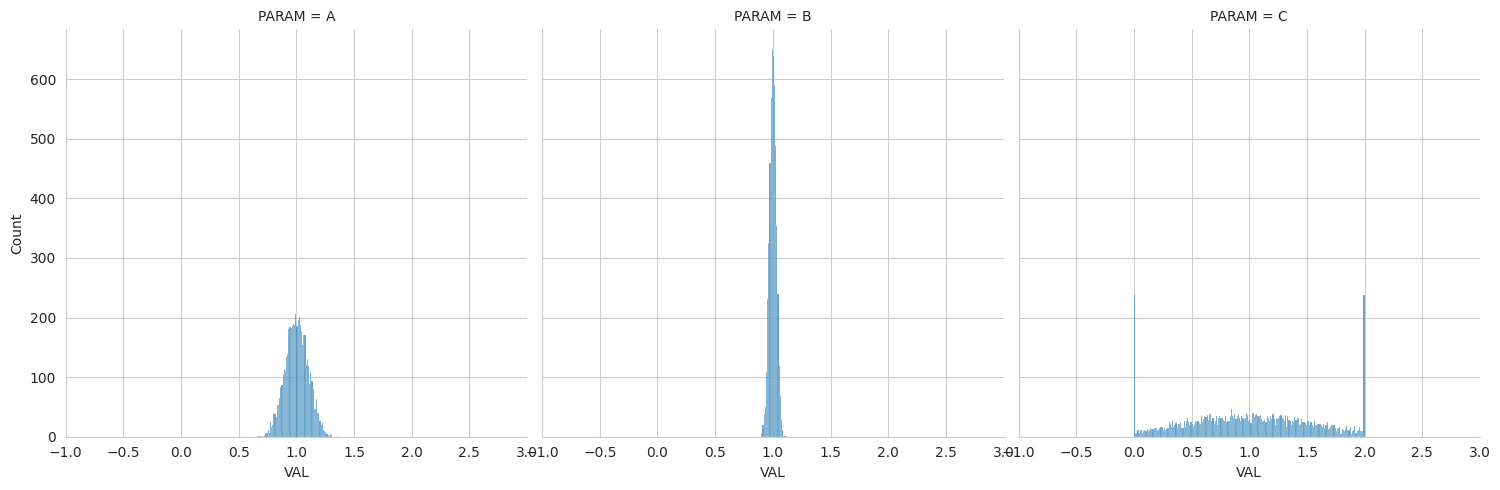

In [8]:
g = sns.displot(data=data, x="VAL", col="PARAM")
plt.xlim(-1, 3);

This behavior can be avoided when sampling from a lognormal distribution. 

## Retrieve mean and covariance matrix of underlying normal distribution

Two-step approach to sample log-normally distributed variables with mean vector $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$:

- draw normally-distributed samples with underlying mean vector $\mathbf{\mu_N}$ and covariance matrix $\mathbf{\Sigma}_N$;
- apply an exponential operator to the normally-distributed samples.

$$
log\mathcal{N} \left( \mathbf{\mu}, \mathbf{\Sigma} \right) = exp \left( \mathcal{N} \left( \mathbf{\mu}_N, \mathbf{\Sigma}_N \right) \right)
$$

The underlying mean vector $\mathbf{\mu}_N$ and covariance matrix $\mathbf{\Sigma}_N$ can be defined starting from $\mathbf{\mu}$ and $\mathbf{\Sigma}$ as defined in https://doi.org/10.1016/j.nima.2013.06.025

$$
\mu_{N_i} = ln \left(\mu_i\right) - \frac{\sigma_i^2}{2}
$$

$$
\sigma_{N_i} = \sqrt{ln\left( 1 + \frac{\sigma_i^2}{\mu_i^2}\right)}
$$

$$
\Sigma_{N_{i,j}} = ln\left( 1 + \frac{\Sigma_{i,j}^2}{\mu_i\mu_j}\right)
$$

If the mean vector is $\mathbf{\mu}=\mathbf{1}$, the equations above simplify to

$$
\mu_{N_i} =  - \frac{\sigma_i^2}{2}
$$

$$
\sigma_{N_i} = \sqrt{ln\left( 1 + \sigma_i^2 \right)}
$$

$$
\Sigma_{N_{i,j}} = ln\left( 1 + \Sigma_{i,j}\right)
$$

In [9]:
mean_N = - np.diag(cov_r.data) / 2
cov_N = np.log(cov_r.data + 1)

## Sampling from normal distribution

In [10]:
nsmp = 10000
y = np.random.randn(3, nsmp)
L = np.linalg.cholesky(cov_N)
smp_N = L.dot(y) + mean_N.reshape(-1, 1)

In [11]:
smp_LogN = np.exp(smp_N)

### Sample analysis

In [12]:
data = pd.DataFrame(smp_LogN, index=parameters)
data.index.name = "PARAM"
data.columns.name = "SMP"
data = data.stack().rename("VAL").reset_index()

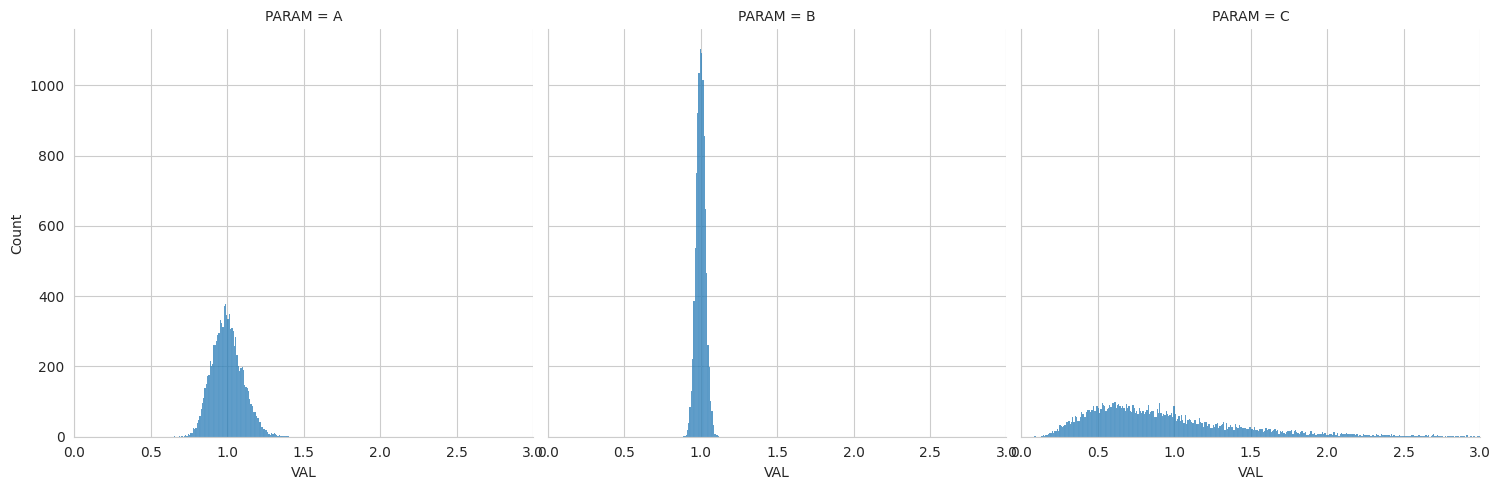

In [13]:
g = sns.displot(data=data, x="VAL", col="PARAM")
plt.xlim(0, 3);

In [14]:
data.groupby("PARAM").VAL.describe()

,count,mean,std,min,25%,50%,75%,max
PARAM,,,,,,,,
A,1.00000e+04,1.00087e+00,1.00257e-01,6.50341e-01,9.31164e-01,9.95022e-01,1.06345e+00,1.39818e+00
B,1.00000e+04,9.99583e-01,2.98119e-02,8.86217e-01,9.79312e-01,9.99500e-01,1.01955e+00,1.11569e+00
C,1.00000e+04,9.65738e-01,5.89883e-01,7.97957e-02,5.70550e-01,8.28318e-01,1.19807e+00,8.78378e+00


The shape, mean and standard deviations of the lognormal samples look correct!

In [15]:
data.pivot_table(index="SMP", columns="PARAM", values="VAL").corr()

PARAM,A,B,C
PARAM,,,
A,1.00000e+00,1.89920e-01,-4.05505e-01
B,1.89920e-01,1.00000e+00,4.99880e-01
C,-4.05505e-01,4.99880e-01,1.00000e+00


Also correlations converge to what was is expected.

In [16]:
(data.VAL < 0).any()

False

...and all values the lognormal distribution are obviously positive!

If we multiply the relative samples by the original mean we go back to absolute values.

In [17]:
foo = lambda row: row.VAL * mean[0] if row.PARAM == "A" else row.VAL * mean[1] if row.PARAM == "B" else row.VAL * mean[2]
data["VAL_ABS"]  = data.apply(foo, axis=1)

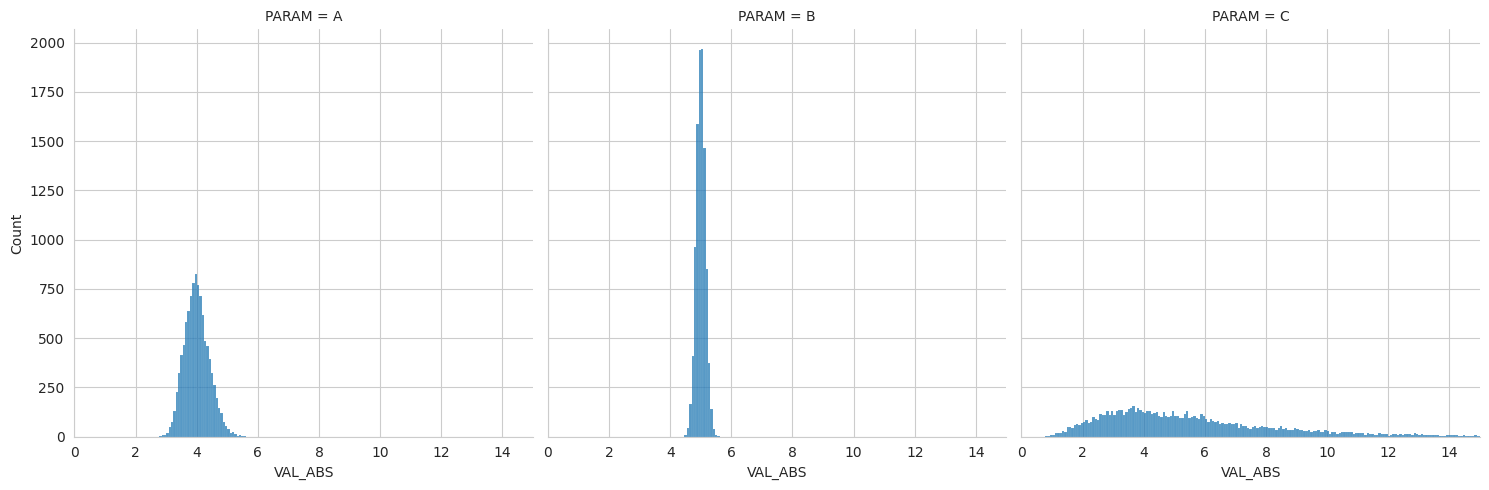

In [18]:
g = sns.displot(data=data, x="VAL_ABS", col="PARAM")
plt.xlim(0, 15);

In [19]:
data.groupby("PARAM").VAL_ABS.describe()

,count,mean,std,min,25%,50%,75%,max
PARAM,,,,,,,,
A,1.00000e+04,4.00347e+00,4.01028e-01,2.60136e+00,3.72466e+00,3.98009e+00,4.25381e+00,5.59270e+00
B,1.00000e+04,4.99791e+00,1.49059e-01,4.43108e+00,4.89656e+00,4.99750e+00,5.09774e+00,5.57843e+00
C,1.00000e+04,5.79443e+00,3.53930e+00,4.78774e-01,3.42330e+00,4.96991e+00,7.18842e+00,5.27027e+01


Relative standard deviation.

In [20]:
data.pivot_table(index="SMP", columns="PARAM", values="VAL_ABS").std() / data.pivot_table(index="SMP", columns="PARAM", values="VAL_ABS").mean()

PARAM
A   1.00170e-01
B   2.98243e-02
C   6.10810e-01
dtype: float64

Correlations.

In [21]:
data.pivot_table(index="SMP", columns="PARAM", values="VAL_ABS").corr()

PARAM,A,B,C
PARAM,,,
A,1.00000e+00,1.89920e-01,-4.05505e-01
B,1.89920e-01,1.00000e+00,4.99880e-01
C,-4.05505e-01,4.99880e-01,1.00000e+00


## Plot sample convergence

For these plots we use the functions and methods already implemented in `sandy`.

In [22]:
nsmp = list(range(10, 1000, 10)) + list(range(1000, 5001, 100))

In [23]:
lognorm = {n: cov_r.sampling(n, pdf="lognormal").data.std() for n in nsmp}
norm = {n: cov_r.sampling(n, pdf="normal").data.std() for n in nsmp}

In [24]:
df = pd.DataFrame(norm).T
df.index.name = "NSMP"
df.columns.name = "PARAM"
dfnorm = df.stack().rename("STD").reset_index().assign(PDF="normal")

df = pd.DataFrame(lognorm).T
df.index.name = "NSMP"
df.columns.name = "PARAM"
dflognorm = df.stack().rename("STD").reset_index().assign(PDF="lognormal")

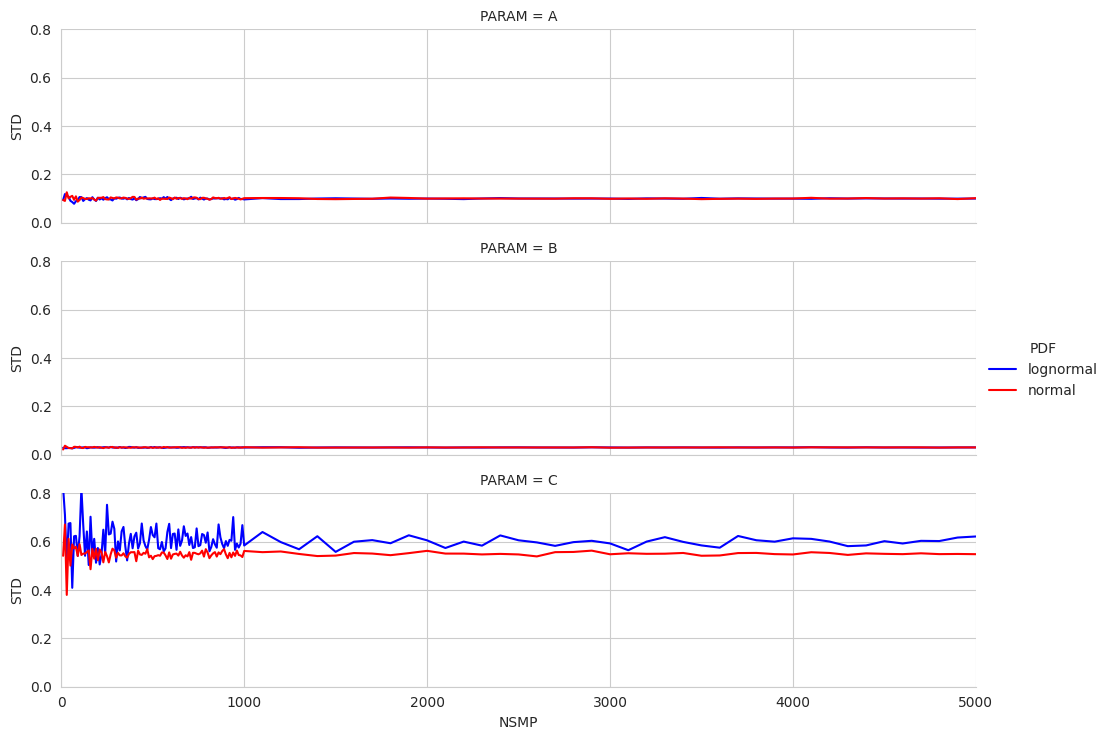

In [25]:
df = pd.concat([dflognorm, dfnorm], ignore_index=True)

g = sns.relplot(
    data=df, x="NSMP", y="STD", row="PARAM",
    hue="PDF", kind="line", palette=["b", "r"],
    height=2.5, aspect=4,
)
g.figure.set_dpi(100)
plt.xlim(0, 5000)
plt.ylim(0, 0.8);

## Plot mean convergence

In [26]:
lognorm = {n: cov_r.sampling(n, pdf="lognormal").data.mean() for n in nsmp}
norm = {n: cov_r.sampling(n, pdf="normal").data.mean() for n in nsmp}

In [27]:
df = pd.DataFrame(norm).T
df.index.name = "NSMP"
df.columns.name = "PARAM"
dfnorm = df.stack().rename("MEAN").reset_index().assign(PDF="normal")

df = pd.DataFrame(lognorm).T
df.index.name = "NSMP"
df.columns.name = "PARAM"
dflognorm = df.stack().rename("MEAN").reset_index().assign(PDF="lognormal")

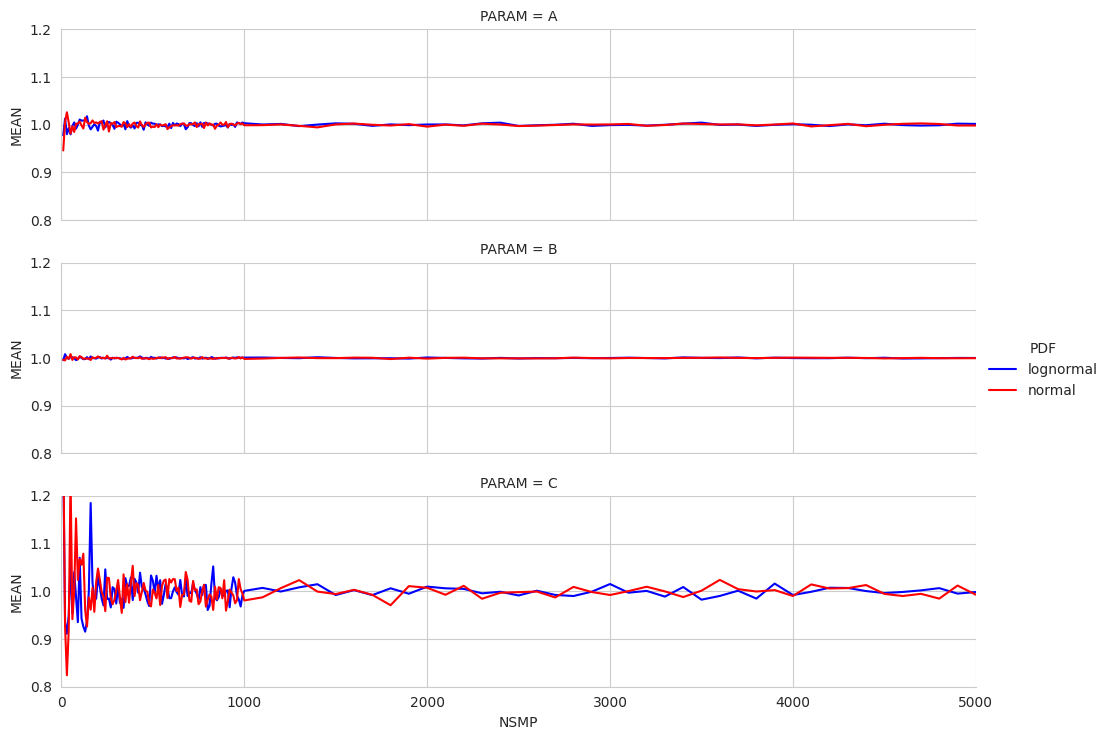

In [28]:
df = pd.concat([dflognorm, dfnorm], ignore_index=True)

g = sns.relplot(
    data=df, x="NSMP", y="MEAN", row="PARAM",
    hue="PDF", kind="line", palette=["b", "r"],
    height=2.5, aspect=4,
)
g.figure.set_dpi(100)
plt.xlim(0, 5000)
plt.ylim(0.8, 1.2);

## Plot correlation convergence

In [29]:
lognorm = {n: cov_r.sampling(n, pdf="lognormal").data.corr().stack().loc[[("A", "B"), ("A", "C"), ("B", "C")]] for n in nsmp}
norm = {n: cov_r.sampling(n, pdf="normal").data.corr().stack().loc[[("A", "B"), ("A", "C"), ("B", "C")]] for n in nsmp}

In [30]:
df = pd.DataFrame(norm).T
df.index.name = "NSMP"
df.columns.names = ("PARAM_1", "PARAM_2")
dfnorm = df.unstack().rename("CORR").reset_index().assign(PDF="normal")

df = pd.DataFrame(lognorm).T
df.index.name = "NSMP"
df.columns.names = ("PARAM_1", "PARAM_2")
dflognorm = df.unstack().rename("CORR").reset_index().assign(PDF="lognormal")

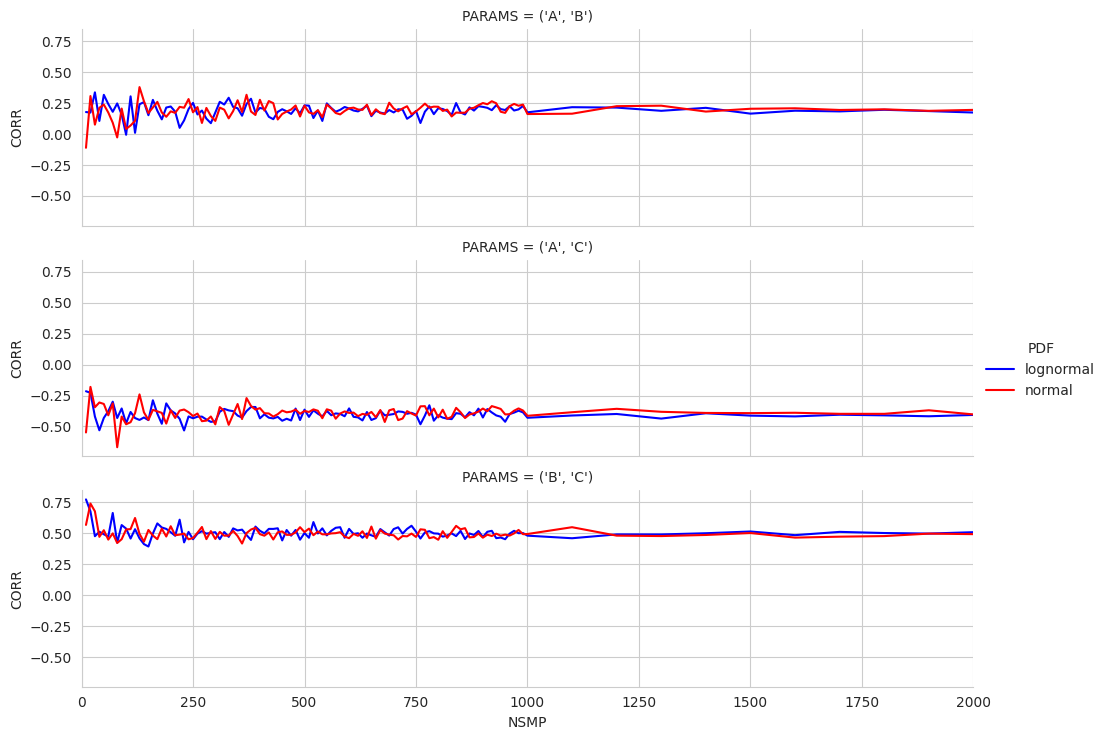

In [31]:
df = pd.concat([dflognorm, dfnorm], ignore_index=True)
df["PARAMS"] = df.apply(lambda row: (row.PARAM_1, row.PARAM_2), axis=1)

g = sns.relplot(
    data=df, x="NSMP", y="CORR", row="PARAMS",
    hue="PDF", kind="line", palette=["b", "r"],
    height=2.5, aspect=4,
)
g.figure.set_dpi(100)
plt.xlim(0, 2000);